In [16]:
def preprocess_crime_data(crime):
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import LabelEncoder
    from pandas.tseries.holiday import USFederalHolidayCalendar
    
    # Ensure 'offense_date' is in datetime format
    crime['offense_date'] = pd.to_datetime(crime['offense_date'], errors='coerce')
    crime.dropna(subset=['offense_date'], inplace=True)

    # Drop unnecessary columns
    cols_to_drop = ['census_tract_geoid', 'census_block_group', 'census_bg_geoid', 'census_block_geoid', 'std_parcelpin',
                    'address_public', 'object_id', 'primary_key', 'case_number', 'reported_date', 'dow_name', 'statute', 
                    'stat_desc', 'date', 'days_ago', 'geoid', 'city', 'zip', 'ward', 'primary_key', 'district', 'time_group', 
                    'census_tract', 'time_block']
    crime = crime.drop(columns=cols_to_drop, errors='ignore')

    # Handle date discrepancies
    crime['extracted_month'] = crime['offense_date'].dt.month
    crime['extracted_day'] = crime['offense_date'].dt.day
    crime = crime.drop(columns=['offense_month', 'offense_day'], errors='ignore')

    # **Extract numeric part from 'census_block' and convert to integer**
    # Extract digits from the 'census_block' string
    crime['census_block'] = crime['census_block'].str.extract('(\d+)', expand=False)

    # Convert to numeric, coercing errors to NaN
    crime['census_block'] = pd.to_numeric(crime['census_block'], errors='coerce')

    # Handle missing values if any (you can choose to drop or fill them)
    # Option 1: Drop rows with missing 'census_block'
    crime.dropna(subset=['census_block'], inplace=True)
    # Option 2: Fill missing values with a default value (e.g., 0)
    # crime['census_block'] = crime['census_block'].fillna(0)

    # Now convert to integer
    crime['census_block'] = crime['census_block'].astype(int)

    # Drop duplicates
    crime = crime.drop_duplicates()

    # Encode cyclical features
    crime['dow'] = crime['offense_date'].dt.weekday + 1  # Monday=1, Sunday=7
    crime['dow_sin'] = np.sin(2 * np.pi * (crime['dow'] - 1) / 7)
    crime['dow_cos'] = np.cos(2 * np.pi * (crime['dow'] - 1) / 7)
    crime['day_sin'] = np.sin(2 * np.pi * (crime['extracted_day'] - 1) / 31)
    crime['day_cos'] = np.cos(2 * np.pi * (crime['extracted_day'] - 1) / 31)
    crime['month_sin'] = np.sin(2 * np.pi * (crime['extracted_month'] - 1) / 12)
    crime['month_cos'] = np.cos(2 * np.pi * (crime['extracted_month'] - 1) / 12)
    crime['hour_sin'] = np.sin(2 * np.pi * crime['hour_of_day'] / 24)
    crime['hour_cos'] = np.cos(2 * np.pi * crime['hour_of_day'] / 24)

    # Drop original cyclical columns
    crime = crime.drop(columns=['dow', 'hour_of_day', 'extracted_month', 'extracted_day'], errors='ignore')

    # Label Encoding
    le_ucr_desc = LabelEncoder()
    crime['ucr_desc_numeric'] = le_ucr_desc.fit_transform(crime['ucr_desc'])
    le_offense_year = LabelEncoder()
    crime['offense_year_numeric'] = le_offense_year.fit_transform(crime['offense_year'])

    # Drop original categorical columns
    crime = crime.drop(columns=['ucr_desc', 'offense_year'], errors='ignore')

    # Feature Engineering
    crime['week_of_year'] = crime['offense_date'].dt.isocalendar().week
    crime['temp_range'] = crime['temp_max'] - crime['temp_min']

    # **Interaction Features**
    crime['week_precipitation_interaction'] = crime['week_of_year'] * crime['precipitation_sum']
    crime['daylight_precipitation_interaction'] = crime['daylight_duration'] * crime['precipitation_sum']
    crime['block_week_interaction'] = crime['census_block'] * crime['week_of_year']
    crime['block_temp_max_interaction'] = crime['census_block'] * crime['temp_max']
    crime['temp_range_precipitation_interaction'] = crime['temp_range'] * crime['precipitation_sum']
    crime['precipitation_sum_hours_interaction'] = crime['precipitation_sum'] * crime['precipitation_hours']

    # Holiday Feature
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=crime['offense_date'].min(), end=crime['offense_date'].max())
    crime['is_holiday'] = crime['offense_date'].dt.normalize().isin(holidays).astype(int)

    return crime

In [17]:
# Function to add weekly crime count lag feature
def add_weekly_lag_features(df, target_column, lags):
    df = df.sort_values(['census_block', 'date'])
    for lag in lags:
        lag_column_name = f"{target_column}_lag{lag}w"
        df[lag_column_name] = df.groupby('census_block')[target_column].shift(lag)
    return df

# Function to add weekly crime count rolling feature
def add_rolling_features(df, target_column, windows):
    df = df.sort_values(['census_block', 'date'])
    for window in windows:
        rolling_column_name = f"{target_column}_rolling{window}"
        df[rolling_column_name] = df.groupby('census_block')[target_column].transform(
            lambda x: x.shift(1).rolling(window=window).mean()
        )
    return df

In [18]:
def create_time_series(data):
    # Preprocess the data
    data = preprocess_crime_data(data)
    
    # Set 'offense_date' as index for grouping
    data.set_index('offense_date', inplace=True)

    # Define the aggregation functions for each feature
    agg_dict = {
        'dow_sin': 'mean',
        'dow_cos': 'mean',
        'day_sin': 'mean',
        'day_cos': 'mean',
        'month_sin': 'mean',
        'month_cos': 'mean',
        'temp_max': 'mean',
        'temp_min': 'mean',
        'temp_range': 'mean',
        'daylight_duration': 'mean',
        'precipitation_sum': 'mean',
        'precipitation_hours': 'mean',
        'week_precipitation_interaction': 'mean',
        'daylight_precipitation_interaction': 'mean',
        'block_week_interaction': 'mean',
        'block_temp_max_interaction': 'mean',
        'temp_range_precipitation_interaction': 'mean',
        'is_holiday': 'mean',
        'week_of_year': 'first',
    }

    # Group by 'census_block_numeric' and weekly intervals
    time_series = data.groupby(['census_block', pd.Grouper(freq='W')]).agg(agg_dict).reset_index()

    # Calculate the weekly crime count per census block
    time_series['Crime_Count_W'] = data.groupby(['census_block', pd.Grouper(freq='W')]).size().values

    # Rename 'offense_date' to 'date' for ease of use
    time_series.rename(columns={'offense_date': 'date'}, inplace=True)

    # Sort the time series
    time_series = time_series.sort_values(by=['census_block', 'date'])

    # Add lag and rolling features
    lag_intervals = [1, 4, 12, 24, 52]
    time_series = add_weekly_lag_features(time_series, target_column='Crime_Count_W', lags=lag_intervals)
    rolling_windows = [2, 3, 4, 8, 15]
    time_series = add_rolling_features(time_series, target_column='Crime_Count_W', windows=rolling_windows)
    
    # Create interaction features
    for window in rolling_windows:
        time_series[f'week_rolling{window}_interaction'] = (
            time_series['week_of_year'] * time_series[f'Crime_Count_W_rolling{window}']
        )
        time_series[f'temp_rolling{window}_interaction'] = (
            time_series['temp_range'] * time_series[f'Crime_Count_W_rolling{window}']
        )
        time_series[f'precip_rolling{window}_interaction'] = (
            time_series['precipitation_hours'] * time_series[f'Crime_Count_W_rolling{window}']
        )

    for lag in lag_intervals:
        time_series[f'daylight_lag{lag}_interaction'] = (
            time_series['daylight_duration'] * time_series[f'Crime_Count_W_lag{lag}w']
        )
        
    time_series = time_series.dropna()

    # Define features to apply log transformation
    log_features = [
        'Crime_Count_W', 
        'Crime_Count_W_lag1w', 'Crime_Count_W_lag4w',
        'Crime_Count_W_lag12w', 'Crime_Count_W_lag24w', 'Crime_Count_W_lag52w',
        'Crime_Count_W_rolling2', 'Crime_Count_W_rolling3', 'Crime_Count_W_rolling4',
        'Crime_Count_W_rolling8', 'Crime_Count_W_rolling15',
        'week_rolling2_interaction', 'temp_rolling2_interaction',
        'precip_rolling2_interaction', 'week_rolling3_interaction',
        'temp_rolling3_interaction', 'precip_rolling3_interaction',
        'week_rolling4_interaction', 'temp_rolling4_interaction',
        'precip_rolling4_interaction', 'week_rolling8_interaction',
        'temp_rolling8_interaction', 'precip_rolling8_interaction',
        'week_rolling15_interaction', 'temp_rolling15_interaction',
        'precip_rolling15_interaction', 'daylight_lag1_interaction',
        'daylight_lag4_interaction', 'daylight_lag12_interaction',
        'daylight_lag24_interaction', 'daylight_lag52_interaction'
    ]
    
    # Apply log1p transformation to specified features
    time_series[log_features] = time_series[log_features].apply(lambda x: np.log1p(x))

    # Reset index
    time_series.reset_index(drop=True, inplace=True)

    return time_series

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from pandas.tseries.holiday import USFederalHolidayCalendar

# Load your data
crime = pd.read_csv(r"\Users\singh\Downloads\crime_with_weather.csv")

# Create time series
crime_time_series = create_time_series(crime)
crime_time_series.to_csv("crime_time_series_2.csv", index=False)

C:\Users\singh\AppData\Local\Temp\ipykernel_458056\2509987584.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv(r"\Users\singh\Downloads\crime_with_weather.csv")


int32


                                 Feature  MI_Score
2                                dow_cos  1.539860
1                                dow_sin  1.253320
12                   precipitation_hours  1.105713
0                           census_block  0.879085
29               Crime_Count_W_rolling15  0.865437
28                Crime_Count_W_rolling8  0.856310
27                Crime_Count_W_rolling4  0.821845
4                                day_cos  0.808163
26                Crime_Count_W_rolling3  0.802596
25                Crime_Count_W_rolling2  0.760730
40             temp_rolling8_interaction  0.753980
43            temp_rolling15_interaction  0.744521
37             temp_rolling4_interaction  0.735172
34             temp_rolling3_interaction  0.732632
31             temp_rolling2_interaction  0.705292
32           precip_rolling2_interaction  0.676521
20                   Crime_Count_W_lag1w  0.669729
21                   Crime_Count_W_lag4w  0.660447
3                              

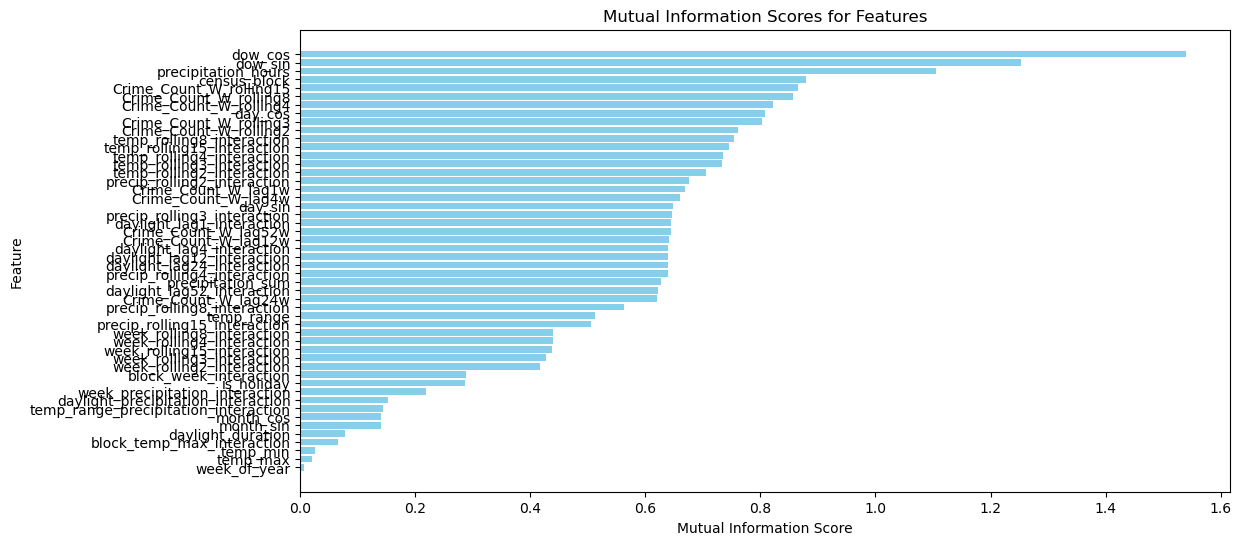

In [20]:
from sklearn.feature_selection import mutual_info_regression

# Separate features and target
X = crime_time_series.drop(columns=['Crime_Count_W', 'date'])  # Features
y = crime_time_series['Crime_Count_W']  # Target variable

# Compute Mutual Information (MI) scores
mi_scores = mutual_info_regression(X, y, random_state=42)

# Create a DataFrame to store feature names and their corresponding MI scores
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values(by='MI_Score', ascending=False)

# Display MI scores
print(mi_df)

# Optional: Plot MI Scores
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(mi_df['Feature'], mi_df['MI_Score'], color='skyblue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Mutual Information Scores for Features')
plt.gca().invert_yaxis()  # Reverse order for better visualization
plt.show()

In [21]:
def prepare_future_data(time_series):
    import numpy as np
    import pandas as pd
    from pandas.tseries.holiday import USFederalHolidayCalendar
    
    # Get the last date and add one week
    last_date = time_series['date'].max()
    future_date = last_date + pd.Timedelta(weeks=1)

    # Create future data for each census block
    census_blocks = time_series['census_block'].unique()
    future_data = pd.DataFrame({
        'census_block': census_blocks,
        'date': future_date
    })

    # Merge with historical data to get features
    combined_data = pd.concat([time_series, future_data], ignore_index=True)
    combined_data = combined_data.sort_values(['census_block', 'date']).reset_index(drop=True)

    # Recompute lag and rolling features
    lag_intervals = [1, 4, 12, 24, 52]
    combined_data = add_weekly_lag_features(combined_data, target_column='Crime_Count_W', lags=lag_intervals)
    rolling_windows = [2, 3, 4, 8, 15]
    combined_data = add_rolling_features(combined_data, target_column='Crime_Count_W', windows=rolling_windows)

    # Identify future data indices
    future_indices = combined_data['date'] == future_date

    # Recompute 'week_of_year' for future date
    combined_data.loc[future_indices, 'week_of_year'] = future_date.isocalendar()[1]

    # Compute cyclical features based on 'date'
    combined_data['dow'] = combined_data['date'].dt.weekday + 1  # Monday=1, Sunday=7
    combined_data['dow_sin'] = np.sin(2 * np.pi * (combined_data['dow'] - 1) / 7)
    combined_data['dow_cos'] = np.cos(2 * np.pi * (combined_data['dow'] - 1) / 7)
    combined_data['day'] = combined_data['date'].dt.day
    combined_data['day_sin'] = np.sin(2 * np.pi * (combined_data['day'] - 1) / 31)
    combined_data['day_cos'] = np.cos(2 * np.pi * (combined_data['day'] - 1) / 31)
    combined_data['month'] = combined_data['date'].dt.month
    combined_data['month_sin'] = np.sin(2 * np.pi * (combined_data['month'] - 1) / 12)
    combined_data['month_cos'] = np.cos(2 * np.pi * (combined_data['month'] - 1) / 12)

    # Compute 'is_holiday' for all dates
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=combined_data['date'].min(), end=combined_data['date'].max())
    combined_data['is_holiday'] = combined_data['date'].dt.normalize().isin(holidays).astype(int)

    # For features that need to be estimated for the future week, use historical averages
    features_to_estimate = [
        'temp_max', 'temp_min', 'precipitation_hours', 'precipitation_sum', 'daylight_duration'
    ]

    for feature in features_to_estimate:
        if feature in combined_data.columns:
            # Use historical average
            historical_mean = combined_data.loc[~future_indices, feature].mean()
            combined_data.loc[future_indices, feature] = historical_mean

    # Recompute 'temp_range' after filling 'temp_max' and 'temp_min'
    combined_data['temp_range'] = combined_data['temp_max'] - combined_data['temp_min']

    # Recompute interaction features
    combined_data['week_precipitation_interaction'] = combined_data['week_of_year'] * combined_data['precipitation_sum']
    combined_data['daylight_precipitation_interaction'] = combined_data['daylight_duration'] * combined_data['precipitation_sum']
    combined_data['block_week_interaction'] = combined_data['census_block'] * combined_data['week_of_year']
    combined_data['block_temp_max_interaction'] = combined_data['census_block'] * combined_data['temp_max']
    combined_data['temp_range_precipitation_interaction'] = combined_data['temp_range'] * combined_data['precipitation_sum']
    combined_data['precipitation_sum_hours_interaction'] = combined_data['precipitation_sum'] * combined_data['precipitation_hours']

    # Create interaction features involving lag and rolling features
    for window in rolling_windows:
        combined_data[f'week_rolling{window}_interaction'] = (
            combined_data['week_of_year'] * combined_data[f'Crime_Count_W_rolling{window}']
        )
        combined_data[f'temp_rolling{window}_interaction'] = (
            combined_data['temp_range'] * combined_data[f'Crime_Count_W_rolling{window}']
        )
        combined_data[f'precip_rolling{window}_interaction'] = (
            combined_data['precipitation_hours'] * combined_data[f'Crime_Count_W_rolling{window}']
        )

    for lag in lag_intervals:
        combined_data[f'daylight_lag{lag}_interaction'] = (
            combined_data['daylight_duration'] * combined_data[f'Crime_Count_W_lag{lag}w']
        )

    # Apply log transformation to the relevant features
    log_features = [
        'Crime_Count_W', 
        'Crime_Count_W_lag1w', 'Crime_Count_W_lag4w',
        'Crime_Count_W_lag12w', 'Crime_Count_W_lag24w', 'Crime_Count_W_lag52w',
        'Crime_Count_W_rolling2', 'Crime_Count_W_rolling3', 'Crime_Count_W_rolling4',
        'Crime_Count_W_rolling8', 'Crime_Count_W_rolling15',
        'week_rolling2_interaction', 'temp_rolling2_interaction',
        'precip_rolling2_interaction', 'week_rolling3_interaction',
        'temp_rolling3_interaction', 'precip_rolling3_interaction',
        'week_rolling4_interaction', 'temp_rolling4_interaction',
        'precip_rolling4_interaction', 'week_rolling8_interaction',
        'temp_rolling8_interaction', 'precip_rolling8_interaction',
        'week_rolling15_interaction', 'temp_rolling15_interaction',
        'precip_rolling15_interaction', 'daylight_lag1_interaction',
        'daylight_lag4_interaction', 'daylight_lag12_interaction',
        'daylight_lag24_interaction', 'daylight_lag52_interaction'
    ]

    # Ensure all log features are present
    existing_log_features = [feature for feature in log_features if feature in combined_data.columns]

    combined_data[existing_log_features] = combined_data[existing_log_features].apply(lambda x: np.log1p(x))

    # Extract future data
    future_data_prepared = combined_data[future_indices].copy()

    # Clean up unnecessary columns if needed
    columns_to_drop = ['dow', 'day', 'month']  # Drop if these are not needed
    future_data_prepared = future_data_prepared.drop(columns=columns_to_drop, errors='ignore')

    return future_data_prepared

In [22]:
future_data = prepare_future_data(crime_time_series)
future_data.describe()

,census_block,date,dow_sin,dow_cos,day_sin,day_cos,month_sin,month_cos,temp_max,temp_min,...,precip_rolling8_interaction,week_rolling15_interaction,temp_rolling15_interaction,precip_rolling15_interaction,daylight_lag1_interaction,daylight_lag4_interaction,daylight_lag12_interaction,daylight_lag24_interaction,daylight_lag52_interaction,precipitation_sum_hours_interaction
count,181.000000,181,1.810000e+02,1.810000e+02,1.810000e+02,1.810000e+02,181.0,1.810000e+02,1.810000e+02,1.810000e+02,...,177.000000,172.0,172.000000,172.000000,181.000000,178.000000,175.000000,167.000000,155.000000,1.810000e+02
mean,2670.878453,2024-10-13 00:00:00,-7.818315e-01,6.234898e-01,6.513725e-01,-7.587581e-01,-1.0,-1.836970e-16,6.071550e+01,4.670416e+01,...,2.127858,4.160726,3.119564,2.158024,10.854371,11.072059,11.079773,11.080310,11.151788,6.379242e-01
min,1000.000000,2024-10-13 00:00:00,-7.818315e-01,6.234898e-01,6.513725e-01,-7.587581e-01,-1.0,-1.836970e-16,6.071550e+01,4.670416e+01,...,1.538669,3.502798,2.485477,1.581791,10.335461,10.335461,10.335461,10.335461,10.335461,6.379242e-01
25%,1045.000000,2024-10-13 00:00:00,-7.818315e-01,6.234898e-01,6.513725e-01,-7.587581e-01,-1.0,-1.836970e-16,6.071550e+01,4.670416e+01,...,1.793294,3.724018,2.695757,1.766440,10.335461,10.335461,10.335461,10.335461,10.796010,6.379242e-01
50%,2048.000000,2024-10-13 00:00:00,-7.818315e-01,6.234898e-01,6.513725e-01,-7.587581e-01,-1.0,-1.836970e-16,6.071550e+01,4.670416e+01,...,2.013514,4.060777,3.019732,2.059235,10.796010,11.028592,11.177840,11.028592,11.177840,6.379242e-01
75%,4003.000000,2024-10-13 00:00:00,-7.818315e-01,6.234898e-01,6.513725e-01,-7.587581e-01,-1.0,-1.836970e-16,6.071550e+01,4.670416e+01,...,2.450102,4.535669,3.482402,2.490765,11.177840,11.576542,11.535983,11.556263,11.576542,6.379242e-01
max,6006.000000,2024-10-13 00:00:00,-7.818315e-01,6.234898e-01,6.513725e-01,-7.587581e-01,-1.0,-1.836970e-16,6.071550e+01,4.670416e+01,...,3.019751,5.136808,4.074358,3.058407,11.894608,12.134565,12.141665,12.170697,12.158340,6.379242e-01
std,1414.585344,NaN,1.447294e-15,1.558624e-15,8.906422e-16,2.560596e-15,0.0,2.224826e-31,7.837651e-14,1.923787e-13,...,0.416308,0.467793,0.454862,0.422491,0.434147,0.584092,0.581978,0.595868,0.565031,1.558624e-15


In [23]:
future_data.to_csv("future_data.csv", index=False)